# Introduction

Jim and Pam are very hungry. After a long day of work at The Office of University Life, they decided to figure out a place to eat. Too bad they didn't have Yelp installed, they had something better. They were Data Scientists!

<img src="./images/wow.jpeg" width=500px></img>

I know, WOW INDEED. A Data Scientist is many things: primarily they are multi-discliplinary wizards that extract insights from data by leveraging a wide variety of tools and skills. These insights are typically serve to answer lucrative or interesting questions like:

- How can we improve productivity in the Office of University Life?
- How can we rig an election?
- What is the spatial distribution hot dog carts in NYC throughout the day?

*Data Science is recognized as one of the hottest fields there is being named the "Sexiest Job of the 21st Century" in 2012, but since then it has become somewhat of a buzzword with negative connotations. With widespread access to user data and large scale hacks compromising private data on millions of people, data is constantly being exploited to target users. With increasing ethical dilemmas about the misuse of data, new laws like the EU's [GDPR](https://eugdpr.org/) are being established to prevent exploitation of users data.*

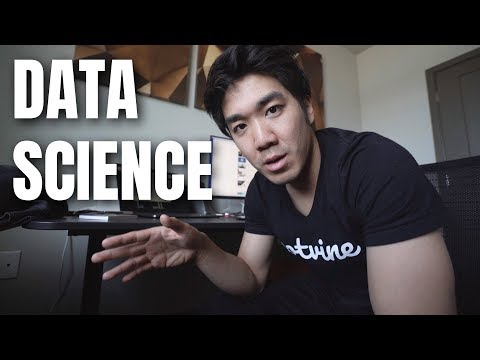

In [4]:
from IPython.display import YouTubeVideo

YouTubeVideo('xC-c7E5PK0Y', width=800, height=500)

Ok back to Jim and Pam, they are data scientists and they need to solve the problem of soothing their aching bellies by fufilling their yearning for the sweet taste of food. So here they go.

## Structure of this First Part

- Using requests and an API
- Modifying Sample Code
- Getting Data
- Making Data Easier to work with

# Requirements for the Data Analysis

requests==2.18.4 

API_KEY = YlHRdziZQHwuA-zsqe8cdJd24fSpn6ImQUVnK2ifVExw52A8o6kSnjw2mxtIR-3X0U0fBdVBWDppPv7MWyWr4xoBSeFjBgz9k5yP7S_MMxKTDFWqKOATeUTHRxMjXHYx

pandas==0.20.1

geojsonio==0.0.3

CLIENT_ID = dLQC-YFBm9Sjlrw_1z9OTQ

# Imports

[API](https://en.wikipedia.org/wiki/Application_programming_interface) or Application Programming Interface is a method of interacting with a programs resources, like Yelp. From [Yelp's Github Repository](https://github.com/Yelp/yelp-fusion/blob/master/fusion/python/sample.py), we can define functions that we can then use to get our first data from Yelp!

<img src="./images/Yelp_Logo.png" width=500px></img>

<br>
<br>
<br>

<center> These code snippets were modified from the sample code provided by Yelp. </center>

In [7]:
from __future__ import print_function

#import argparse
import json
import pprint
import requests
import sys
import urllib

#Code based off of the sample.py from YELP's API 

try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode
    
API_KEY= "YlHRdziZQHwuA-zsqe8cdJd24fSpn6ImQUVnK2ifVExw52A8o6kSnjw2mxtIR-3X0U0fBdVBWDppPv7MWyWr4xoBSeFjBgz9k5yP7S_MMxKTDFWqKOATeUTHRxMjXHYx"

import pandas as pd
from PIL import Image

# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
REVIEW_PATH = '/v3/businesses/{}/reviews'

# Defaults for our simple example.
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 10

def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location, limit=SEARCH_LIMIT):
    """Query the Search API by a search term and location.
    
    Can add additional terms:
    
        sort_by (string) Optional. Suggestion to the search algorithm that the results be sorted by one of the these
            modes: best_match, rating, review_count or distance. The default is best_match. Note that specifying the
            sort_by is a suggestion (not strictly enforced) to Yelp's search, which considers multiple input parameters
            to return the most relevant results. For example, the rating sort is not strictly sorted by the rating value,
            but by an adjusted rating value that takes into account the number of ratings, similar to a Bayesian average. 
            This is to prevent skewing results to businesses with a single review.
            
        price (string) Optional. Pricing levels to filter the search result with: 1 = $, 2 = $$, 3 = $$$, 4 = $$$$. 
            The price filter can be a list of comma delimited pricing levels. For example, "1, 2, 3" will filter the
            results to show the ones that are $, $$, or $$$.
            
        open_now (boolean) Optional. Default to false. When set to true, only return the businesses open now.
            Notice that open_at and open_now cannot be used together.
    
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': limit
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(API_KEY, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, API_KEY)

def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)
    return response

def query_api_limits(term, location, num_limit = 10):
    """Queries the API by the input values from the user. Will get at most num_limit businesses.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
        num_limit (int): Max number of businesses.
    """
    response = search(API_KEY, term, location, limit=num_limit)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_ids = [i['id'] for i in businesses]
    first_business_id = business_ids[0]
    
    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), first_business_id))
    
    responses = [get_business(API_KEY, business_id) for business_id in business_ids]
    
    return responses

def get_reviews(business_id,api_key=API_KEY,limit=3):
    """Query the Review API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    review_path = REVIEW_PATH.format(business_id)
    
    url_params = {
        'limit': limit
    }
    
    return request(API_HOST,review_path, api_key, url_params=url_params)


## Basic Query

Let's first begin with a basic query, reading the documentation of the function we see that we simply need to input our search string followed by a location in order to get data our top result. We that the max number returned is limited by the parameter SEARCH_LIMIT.

In [8]:
response = query_api("dinner", 'Morningside Heights, NY')

Querying https://api.yelp.com/v3/businesses/search ...
10 businesses found, querying business info for the top result "E2mNgb479B3BCfwi2G_KdQ" ...
Querying https://api.yelp.com/v3/businesses/E2mNgb479B3BCfwi2G_KdQ ...
Result for business "E2mNgb479B3BCfwi2G_KdQ" found:
{ 'alias': 'flat-top-new-york',
  'categories': [ {'alias': 'newamerican', 'title': 'American (New)'},
                  {'alias': 'cafes', 'title': 'Cafes'},
                  {'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'}],
  'coordinates': {'latitude': 40.810041, 'longitude': -73.958693},
  'display_phone': '(646) 820-7735',
  'hours': [ { 'hours_type': 'REGULAR',
               'is_open_now': False,
               'open': [ { 'day': 0,
                           'end': '1530',
                           'is_overnight': False,
                           'start': '1130'},
                         { 'day': 0,
                           'end': '2200',
                           'is_overnight': False,
      

This output is really interesting, there seems to be a great amount of data here to work with. Jim and Pam would really first like to see some photos of the food that they serve at the restaurant. It looks like the url of the image is available. Let's quickly take a look at that:

In [10]:
#Getting the URL
URL = response['image_url']

#Writing the URL temporarily
with urllib.request.urlopen(URL) as url:
    with open('temp.jpg', 'wb') as f:
        f.write(url.read())

#Opening the URL
img = Image.open('temp.jpg')

img.show()

<img src='temp.jpg'></img>

Jim and Pam approve, but lets see if we can check out more options.

# Getting Multiple Responses

Let's start getting serious: Looking at these restaurants one at a time is infuriating. What is really nice is that Yelp has already provided us with code that actually works, so let's take advantage of that and adapt "query_api" into a function that can grab many restaurants for us.

```python

def query_api_limits(term, location, num_limit = 10):
    """Queries the API by the input values from the user. Will get at most num_limit businesses.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
        num_limit (int): Max number of businesses.
    """
    response = search(API_KEY, term, location, limit=num_limit)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_ids = [i['id'] for i in businesses]
    first_business_id = business_ids[0]
    
    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), first_business_id))
    
    responses = [get_business(API_KEY, business_id) for business_id in business_ids]
    
    return responses
```

The function above is adapted to our liking now, we see that we can actually return a list of businesses. Let's see if we can try that out.

In [19]:
responses = query_api_limits("", 'Morningside Heights, NY')

Querying https://api.yelp.com/v3/businesses/search ...
10 businesses found, querying business info for the top result "JV5oa5-KGdiWnqrKPoxSug" ...
Querying https://api.yelp.com/v3/businesses/JV5oa5-KGdiWnqrKPoxSug ...
Querying https://api.yelp.com/v3/businesses/QHYqNQhQ8NVK0RX68Y4PuQ ...
Querying https://api.yelp.com/v3/businesses/8lLs3dsSN-Am2_EtNfbXqA ...
Querying https://api.yelp.com/v3/businesses/vZ5-JXlJS75k8wmPNS5U5w ...
Querying https://api.yelp.com/v3/businesses/8Qe6g3Dv5NXN1Zq-egJk9w ...
Querying https://api.yelp.com/v3/businesses/7tTVuBwJ4LLtQ3-HHW80_A ...
Querying https://api.yelp.com/v3/businesses/E2mNgb479B3BCfwi2G_KdQ ...
Querying https://api.yelp.com/v3/businesses/80fvd_DsoW5XhwQIMBGvtg ...
Querying https://api.yelp.com/v3/businesses/A46G2OAvLxFswiONB50Rrg ...
Querying https://api.yelp.com/v3/businesses/C2E1E0o-ssSrf_dokwxTXg ...


Seemed like it works! But the data is kinda terrible looking not gonna lie (ngl). Therefore we are going to introduce something really quite powerful.

<img src="./images/panda.gif"></img>

OOOOO its about to get real. We are gonna introduce PANDAS. Pandas is a package that most data scientists like to use. It's a really great way for storing data and performing data analysis and is widely used by data scientists. Here we are going to discuss the one of the key data structure in Pandas: the DataFrame.

## Basics of the DataFrame

[Here](https://pandas.pydata.org/pandas-docs/stable/10min.html) is a very short introduction on how to use Pandas. I would also recommend taking a look at this [resource](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html) as well before you move on.

## Using the DataFrame to store our Data

Alright, now Jim and Pam are going to store their data into a DataFrame, let's write some simple functions to do that:

In [16]:
def create_new_entry(metadata):
    """
    Reads in the metadata from a response from query_api and stores individual entries into a pandas DataFrame
    
    Args:
        param1: metadata (dict) stores the response from query_api
        
    Returns:
        pandas.DataFrame with one entry
    """
    new_entry = dict()
    new_entry['id']=metadata['id']
    new_entry['name']=metadata['name']
    new_entry['review_count'] =metadata['review_count']
    new_entry['rating']=metadata['rating']
    new_entry['latitude']=metadata['coordinates']['latitude']
    new_entry['longitude']=metadata['coordinates']['longitude']
    new_entry['open']=metadata['hours'][0]['is_open_now']
    return pd.DataFrame(new_entry,index=[0])

def creatingDataFrame(responses):
    """
    Reads in a list of responses from query_api and stores the entries all in a pandas DataFrame using create_new_entry
    
    Args:
        param1: responses (list) stories responses from query_api
        
    Returns:
        pandas.DataFrame with all responses as entries
    """
    output= pd.concat([create_new_entry(response) for response in responses])
    output = output.reset_index(drop=True)
    return output

def create_category_entry(metadata):
    """
    Method to record the categories of restaurant the response from query_api in a pandas.DataFrame
    
    Args:
        param1: metadata (dict) stores the response from query_api
        
    Returns:
        pandas.DataFrame with entries with the 'id' of the restaurant and the associated categorization
    """
    new_entry=dict()
    categories=dict()
    new_entry['id']=metadata['id']
    for i in range(len(metadata['categories'])):
        categories[i]=metadata['categories'][i]
    new_entry['categories']=categories
    return pd.DataFrame(new_entry)

def createCategoryDataFrame(responses):
    """
    Method to record the categories of restaurants the responses from query_api in a pandas.DataFrame
    
    Args:
        param1: responses (list) stories responses from query_api
        
    Returns:
        pandas.DataFrame with entries with the 'id's of the restaurants and their associated categorizations
    """
    output = pd.concat([create_category_entry(response) for response in responses])
    output = output.reset_index(drop=True)
    return output

In [24]:
restaurant_DataFrame = creatingDataFrame(responses)

In [25]:
category_DataFrame= createCategoryDataFrame(responses)

In [27]:
restaurant_DataFrame.head()

,id,name,review_count,rating,latitude,longitude,open
0,JV5oa5-KGdiWnqrKPoxSug,Absolute Bagels,1229,4.5,40.802510,-73.967450,False
1,QHYqNQhQ8NVK0RX68Y4PuQ,Levain Bakery,631,4.5,40.804974,-73.955151,False
2,8lLs3dsSN-Am2_EtNfbXqA,Community Food & Juice,847,3.5,40.805798,-73.965675,False
3,vZ5-JXlJS75k8wmPNS5U5w,Max Soha,386,4.0,40.811302,-73.958183,False
4,8Qe6g3Dv5NXN1Zq-egJk9w,Hungarian Pastry Shop,597,3.5,40.803580,-73.963650,False


In [28]:
category_DataFrame.head()

,id,categories
0,JV5oa5-KGdiWnqrKPoxSug,"{'alias': 'bakeries', 'title': 'Bakeries'}"
1,JV5oa5-KGdiWnqrKPoxSug,"{'alias': 'bagels', 'title': 'Bagels'}"
2,QHYqNQhQ8NVK0RX68Y4PuQ,"{'alias': 'bakeries', 'title': 'Bakeries'}"
3,8lLs3dsSN-Am2_EtNfbXqA,"{'alias': 'newamerican', 'title': 'American (N..."
4,8lLs3dsSN-Am2_EtNfbXqA,"{'alias': 'breakfast_brunch', 'title': 'Breakf..."


In [36]:
location_ids = [location_id for location_id in category_DataFrame['id'].unique()]

In [37]:
location_ids

['JV5oa5-KGdiWnqrKPoxSug',
 'QHYqNQhQ8NVK0RX68Y4PuQ',
 '8lLs3dsSN-Am2_EtNfbXqA',
 'vZ5-JXlJS75k8wmPNS5U5w',
 '8Qe6g3Dv5NXN1Zq-egJk9w',
 '7tTVuBwJ4LLtQ3-HHW80_A',
 'E2mNgb479B3BCfwi2G_KdQ',
 '80fvd_DsoW5XhwQIMBGvtg',
 'A46G2OAvLxFswiONB50Rrg',
 'C2E1E0o-ssSrf_dokwxTXg']

Cool! We have alot of the relevant data we need in order to make an informed decision on where to eat. Now let's say that Jim really wanted a way to have the categories stored in a list so anyone can access this category list uniquely. What is very nice about the location_id is that assuming it is unique, allows us to understand quickly get data on the specific restaurant from either the "restaurant_DataFrame" or the "category_DataFrame" since they share the id row in common.

We are going to now take the category_DataFrame and store it as a dictionary where the key is the location_id and the value is a list of the labels that was categorized.

In [54]:
def collate_data(df,location_id):
    """
    Method to take the category_DataFrame and store it as a dictionary where the key is the location_id and the value is a list of the labels that was categorized.
    
    Args: 
        param1: df (pandas.DataFrame) the input category dataFrame
        param2: location_id (string) unique identifier for the restaurant
        
    Returns
        Dictionary: a dictionary where the key is the location_id and the value is a list of the labels that was categorized.
    """
    if isinstance(location_id, (list,)):
        output=dict()
        
        for loc in location_id:
            aliases = []
            for i in df[df['id']==loc]['categories']:
                aliases.append(i['alias'])
            output[loc]=aliases
        
        return output
    else:
        aliases = []
        for i in tempdf[df['id']==location_id]['categories']:
            aliases.append(i['alias'])
        return {location_id: aliases}

In [55]:
collate_data(cat_tempdf, location_ids)

{'JV5oa5-KGdiWnqrKPoxSug': ['bakeries', 'bagels'],
 'QHYqNQhQ8NVK0RX68Y4PuQ': ['bakeries'],
 '8lLs3dsSN-Am2_EtNfbXqA': ['newamerican', 'breakfast_brunch', 'bars'],
 'vZ5-JXlJS75k8wmPNS5U5w': ['italian'],
 '8Qe6g3Dv5NXN1Zq-egJk9w': ['bakeries', 'coffee'],
 '7tTVuBwJ4LLtQ3-HHW80_A': ['parks'],
 'E2mNgb479B3BCfwi2G_KdQ': ['newamerican', 'cafes', 'breakfast_brunch'],
 '80fvd_DsoW5XhwQIMBGvtg': ['churches', 'landmarks'],
 'A46G2OAvLxFswiONB50Rrg': ['pizza'],
 'C2E1E0o-ssSrf_dokwxTXg': ['ethiopian', 'african', 'bars']}

Jim and Pam had the opportunity to explore their data and now they decided that they want to give restaurant 'QHYqNQhQ8NVK0RX68Y4PuQ' a chance, therefore from now on, we are going to consider this as their_restaurant_id.

In [57]:
their_restaurant_id='QHYqNQhQ8NVK0RX68Y4PuQ'

Now Jim is worried about how good the restaurant really is. He saw on the Yelp page that the rating was a 4.5 but looking at some of the ratings of the three reviews he read he saw a 5 and 2 and a 3.

In [62]:
reviews = get_reviews(their_restaurant_id)['reviews']

Querying https://api.yelp.com/v3/businesses/QHYqNQhQ8NVK0RX68Y4PuQ/reviews ...


In [65]:
reviews[0]['rating']

5

In [66]:
reviews[1]['rating']

2

In [72]:
reviews[2]['rating']

3

*Now what would be a really cool idea would be to try to run Sentiment Analysis on these reviews which can be accessed through the URL. Using a webscraper like BeautifulSoup, one could probably do some really cool analysis. But of course, that step is left as an exercise to the reader :).*

__How can Jim quantify this uneasiness? What should the rating probably be?__

<img src='./images/math.png'></img>

Let's try to use some math/Bayesian Inference.

## Bayesian Inference

Bayesian Inference is a rich and nuanced topic to discuss especially since it is technically a philosophy. There is a whole philisophical competition between [Bayesian](https://rationalwiki.org/wiki/Bayesian) and Frequentist reasoning which is really interesting, but we would like to apply Bayesian Inference to help us guess what the likelihood of a restaurant being a certain rating is.

These were some really great resources that Jim and Pam took direction from:
- https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815
- https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers 

## Let's begin with some imports

In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

# from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# Helper functions
from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

Jim decides to approach the problem like this to make it simpler for himself. He observed the ratings 5, 3, 2 each once and knows that the average should be 4.5 according to the rating of the restaurant. Now the ratings of 3 and 2 hurt how he feels about the 4.5 rating, but can we quantify that? (For now we are going to pretend the ratings of 4 and 1 don't matter)

The average rating of 4.5 reflects our prior beliefs and we can actually tune that in the hyperparameters. Since the average is so high, we strongly believe that we should see alot of 5 ratings in general therefore we phrase the problem accordingly.

In [17]:
# observations
ratings = ['5','4', '3', '2','1']
c = np.array([1, 0,1, 1,0])

# hyperparameters
jims_parameters = np.array([16, 1, 1, 1,1])

We chose the hyperparameters 8,1,1 because if we imagine that they were the number of observations for observing the ratings 5,3,2 respectively then we have an expected value/average of 4.5.

In [3]:
(16*5+4+3+2+1)/(4+16)

4.5

In [4]:
display_probs(dict(zip(ratings, (jims_parameters + c) / (c.sum() + jims_parameters.sum()))))

Rating: 5        Prevalence: 73.91%.
Rating: 4        Prevalence: 4.35%.
Rating: 3        Prevalence: 8.70%.
Rating: 2        Prevalence: 8.70%.
Rating: 1        Prevalence: 4.35%.


The expected value for Jim's rating (with our new observations now) should be:

In [5]:
5*0.7391+4*.0435+3*.0870+2*.0870+1*.0435

4.348

Wow, we were able to quantify how our observations affected Jim's prior beliefs. Now Pam is much more of a believer and her hyperparameters are larger, signaling a stronger belief in the original rating, but with the same expected value.

In [16]:
pams_parameters=np.array([32, 2, 2, 2,2])

In [7]:
display_probs(dict(zip(ratings, (pams_parameters + c) / (c.sum() + pams_parameters.sum()))))

Rating: 5        Prevalence: 76.74%.
Rating: 4        Prevalence: 4.65%.
Rating: 3        Prevalence: 6.98%.
Rating: 2        Prevalence: 6.98%.
Rating: 1        Prevalence: 4.65%.


These are our expected value for Pam's rating (with our new observations now) should be:

In [9]:
5*.7674+4*.0465+3*.0698+2*.0698+1*.0465

4.418499999999999

We see that that Pam is less shaken by negative reviews and her expected value for the rating is less affect in comparison to Jim and we can visualize that as well:

In [18]:
alpha_list=[jims_parameters,pams_parameters]

In [21]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = ratings)
value_df['alphas'] = ["Jim","Pam"] #[str(x) for x in alpha_list]
value_df

,5,4,3,2,1,alphas
0,0.739130,0.043478,0.086957,0.086957,0.043478,Jim
1,0.767442,0.046512,0.069767,0.069767,0.046512,Pam


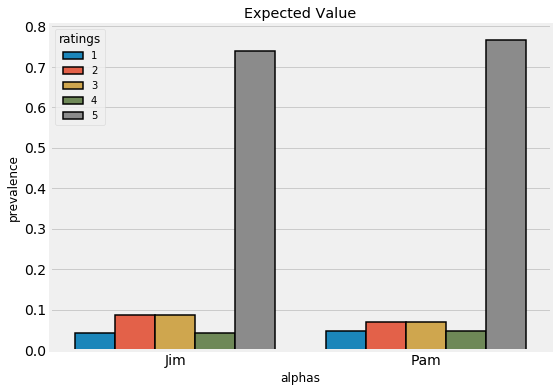

In [22]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'ratings')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'ratings', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

Therefore we see that Pam is a lot less shaken by what she sees in terms of reviews.

# More complicated Analysis

Our overall system has five discrete choices each with an unknown probability and 3 total observations is a multinomial distribution. A multinomial distribution is the generalization of the binomial distribution where there are more than just two outcomes and can be characterized byby k, the number of outcomes, n, the number of trials, and p, a vector of probabilities for each of the outcomes. Our objective is to find p, the probability of seeing each rating in our observations.

"In Bayesian statistics, the parameter vector for a multinomial is drawn from a [Dirichlet Distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution), which forms the prior distribution for the parameter." (Medium Article) Similiar to the multinomial, the Dirichlet Distribution is characterized by, k, the number of outcomes, and alpha, a vector of positive real values called the concentration parameter. Alpha is called a hyperparameter because it is a parameter of the prior.

Let's talk more about the hyperparameters and Jim and Pam's prior beliefs. The way we previously thought about the hyperparameters were as psuedocounts, basically as events that we maybe already have seen. If we have seen much more data, a couple of stray values may not shake up our confidence that much.


## Bayesian Inference in Python with PyMC3

Let's try to get a range of estimates, we use Bayesian inference in order to construct a model of the Jim's feelings as he sees these observations come in, then sample from the posterior to approximate the posterior (the posterior being the end distribution).

In [25]:
with pm.Model() as jims_model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=jims_parameters, shape=5)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=3, p=parameters, shape=3, observed=c)

In [27]:
jims_model

## Sampling from the Model

In [28]:
with jims_model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1601.09draws/s]


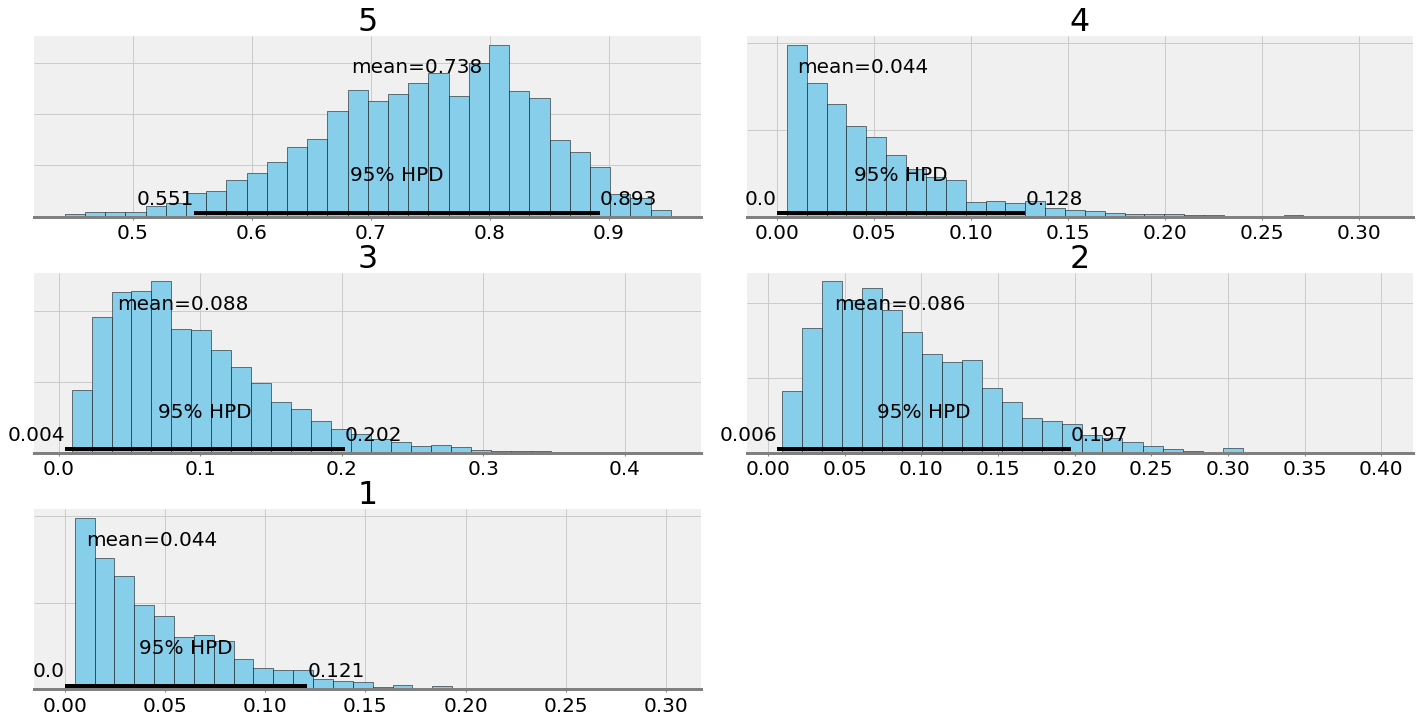

In [29]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(ratings):
    ax[i].set_title(a);

## Posterior Distribution

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


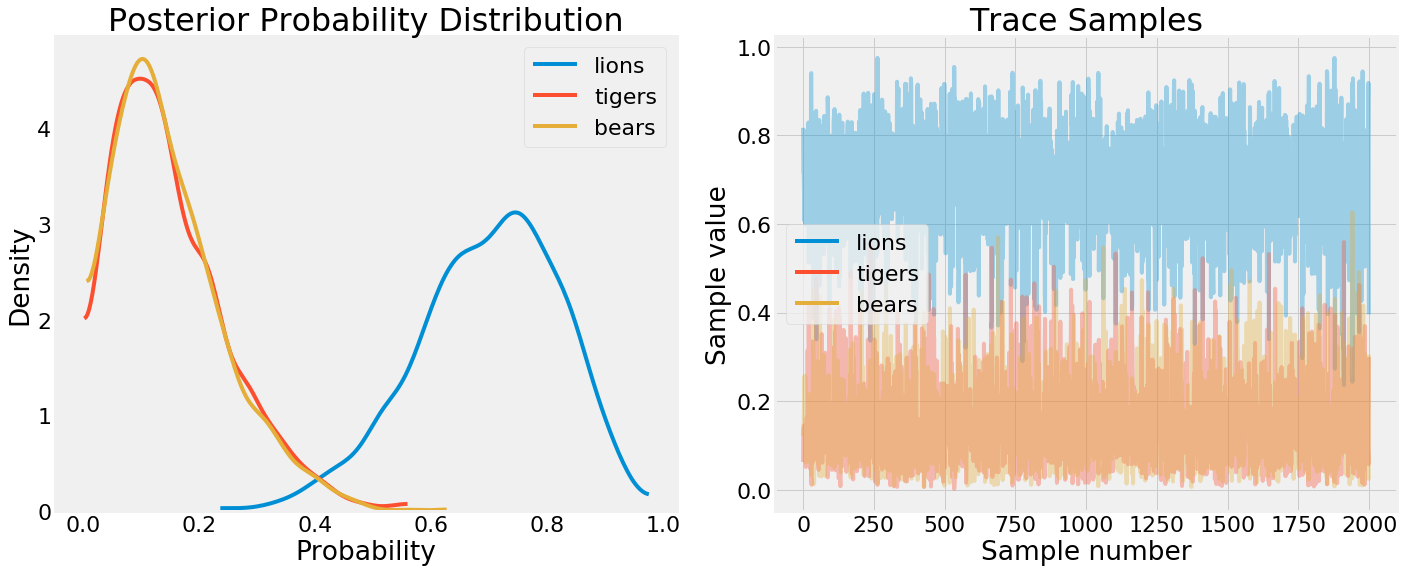

In [148]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');
add_legend(ax[0][0])
add_legend(ax[0][1])

# Checkpoint 1